In [97]:
import pandas as pd
import nltk
import lightgbm
import yellowbrick
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction
from gensim.models import Word2Vec



stopwords = set(stopwords.words('english'))
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Clean

In [126]:
def rm_sw(x): 
    tok = word_tokenize(x)
    l = [word for word in tok if word not in stopwords]
    return l 

def vecs(x): 
    return [Word2Vec(l) for l in x]


train['rm'] = train['text'].apply(rm_sw)
test['rm'] = test['text'].apply(rm_sw)
# model = Word2Vec(train['rm'])
train['text'] = train['rm'].apply(lambda x: ' '.join(x))
test['text'] = test['rm'].apply(lambda x: ' '.join(x))


# Count Vec

In [129]:
cv = feature_extraction.text.CountVectorizer()
train_vectors = cv.fit_transform(train['text'])
test_vectors = cv.transform(test['text'])
train_vectors = train_vectors.astype('float')
test_vectors = test_vectors.astype('float')

train_vectors[0].todense().shape

(1, 21617)

# Train

In [130]:
X_train,X_test,y_train,y_test = train_test_split(
                                        train_vectors, 
                                        train['target'],
                                        stratify=train['target'], 
                                        random_state=0
                                        )

In [131]:
m = lightgbm.LGBMClassifier(
    num_leaves=100,
    max_depth=-2,
    n_estimators=100, 
)
m.fit(X_train, y_train)

LGBMClassifier(max_depth=-2, num_leaves=100)

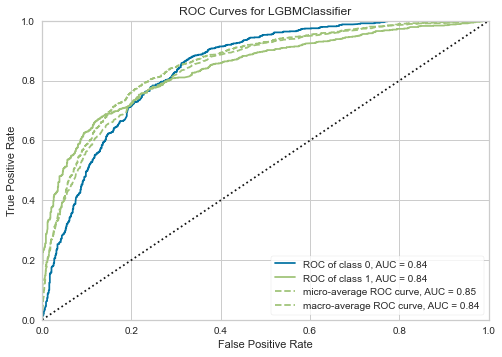

<AxesSubplot:title={'center':'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [132]:
vis = yellowbrick.ROCAUC(m, classes=[0,1])
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()

In [133]:
from sklearn.model_selection import cross_val_score
m = lightgbm.LGBMClassifier(
    num_leaves=100,
    max_depth=-2,
    n_estimators=100, )
scores = cross_val_score(m, X_train, y_train, cv=10, scoring='f1')
scores.mean()

In [ ]:
scores.mean()

0.7297876333849398

# ON Test Set

In [88]:
m = lightgbm.LGBMClassifier()
m.fit(train_vectors, train['target'])
preds = m.predict(test_vectors,)
test['target'] = preds
test.set_index('id')['target'].to_csv('tt.csv')

LGBMClassifier()